# Pearson vs Kendall-tau correlations in RSA

Required imports.

In [1]:
#!conda install numpy matplotlib scipy seaborn tqdm
#!conda install -c conda-forge rsatoolbox scienceplots statsmodels

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.polynomial.polynomial import polyfit

from scipy.stats import pearsonr, kendalltau, normaltest, kstest
from scipy.special import erf
from scipy.optimize import newton

from statsmodels.distributions.copula.api import GaussianCopula

from tqdm import tqdm

import scienceplots

import rsatoolbox as rt

In [3]:
# Setup plotting style
plt.style.use(['science', 'grid', 'bright'])
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times'],
    'font.size': 10
})

figwidth_thesis = 5.5
#figwidth_thesis = 7
figheight_thesis = figwidth_thesis/1.618
dpi_thesis = 600

#sns.set(rc={'figure.figsize':(figwidth_thesis, figheight_thesis)})

## 1. Generation of Data

The role of bimodal distribution plays bimodal normal distribution, denoted by $BN(\mu, \sigma, \alpha)$. Distribution doesn't change over the course of research, parameters are set here. We also need to estimate quantile function, which we do by fitting polynomial onto points samples from CDF. We also defined functions that will help us in calculations.

In [4]:
def binormal_cdf(x, mu, sigma, alpha):
    res = 0.25 * (2 + 
                  erf((x-mu-alpha*sigma)/(sigma*np.sqrt(2))) + 
                  erf((x-mu+alpha*sigma)/(sigma*np.sqrt(2))))
    return res

def binormal_pdf(x, mu, sigma, alpha):
    res = 1/(np.sqrt(2 * np.pi * sigma**2)) * np.exp(-0.5 * ((x-mu)/sigma)**2 - alpha**2/2) * np.cosh(alpha*(x-mu)/sigma)
    return res

def eval_poly(x, coef_arr):
    res = 0
    deg = 0
    for c in coef_arr:
        res += c * (x ** deg)
        deg += 1
    return res

In [5]:
# Parameters of bimodal normal distribution
mu = 0
sigma = 1
alpha = 2

# Sample points form cdf
arr_x = np.arange(-5, 5, 0.1)
arr_cdf = binormal_cdf(arr_x, mu, sigma, alpha)

# Fit polynomial onto sampled cdf points with axes switched (to get an estimation of quantile function)
coef_arr = polyfit(arr_cdf, arr_x, 17)

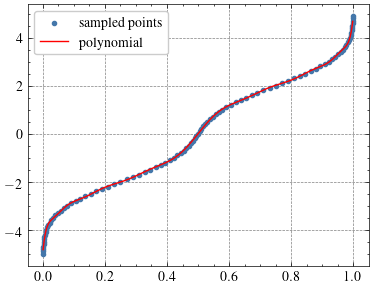

In [6]:
# Plot fitted polynomial curve
temp = np.arange(0.001, 0.999, 0.001)
arr_ppf_exact = eval_poly(temp, coef_arr)

plt.figure(figsize=(figwidth_thesis*0.8, figheight_thesis))
plt.scatter(arr_cdf, arr_x, label='sampled points', marker='.')
plt.plot(temp, arr_ppf_exact, label='polynomial', color='red')
plt.legend()
plt.savefig('gen_bimodal_polynomial.png', dpi=dpi_thesis)

In [7]:
coef_arr

array([-4.96085472e+00,  1.44196485e+02, -6.82941712e+03,  1.89742687e+05,
       -3.18153847e+06,  3.46136561e+07, -2.57924309e+08,  1.36732950e+09,
       -5.29278970e+09,  1.52133358e+10, -3.27680026e+10,  5.29880886e+10,
       -6.39484267e+10,  5.66960088e+10, -3.58271599e+10,  1.52665551e+10,
       -3.93031163e+09,  4.61682030e+08])

C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


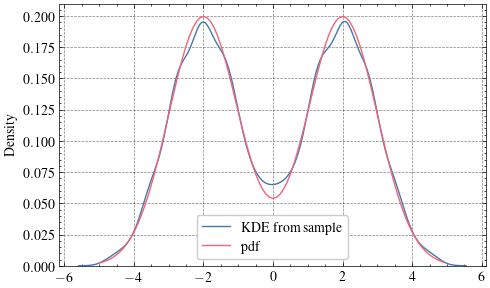

In [8]:
# Plot PDF
sample_bn_numerical = np.zeros(50000)
for i in range(50000):
    x = np.random.uniform(0.001, 0.999)
    sample_bn_numerical[i] = eval_poly(x, coef_arr)

#plt.hist(sample_bn_numerical, bins=50)
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
sns.kdeplot(sample_bn_numerical, label='KDE from sample')

# Reference
arr_pdf_analytic = binormal_pdf(arr_x, mu, sigma, alpha)
plt.plot(arr_x, arr_pdf_analytic, label='pdf')
plt.legend(loc='lower center')
plt.savefig("gen_bimodal_pdf_kde.png", dpi=dpi_thesis)

The first thing is to properly generate synthetic data. We start with generating one-dimensional data, then use it later to generate arrays of data with higher dimensionality.

### 1.1. Generation of 1D data

The function to generate two sequences of numbers that are corelated to some predefined extent.

Function implementation:

In [9]:
def gen_data_1d(corr = 0.5, n = 50, plotting = False, dist = 'normal'):
    """
    Generates two 1-D arrays of initial data with given correlation (or rather, close to it) and with given amount of elements.
    
    Parameters of distributions used for generation are defined inside the function.
    
    For normal distribution, mu=0, std=1.
    For uniform, a=0, b=1.
    For bimodal, mu=0, sigma=1, alpha=2.
    """
    
    assert corr >= -1.0 and corr <= 1.0
    assert n > 0
    assert dist in ['uniform', 'normal', 'bimodal']
    
    # Array X - random points from one of random distributions
    x = None
    y = None
    if dist == 'uniform':
        gc = GaussianCopula(corr=corr, k_dim=2, allow_singular=True)
        res = gc.rvs(n)
        x = res[:,0]
        y = res[:,1]
    elif dist == 'normal':
        mean = np.array([0.0, 0.0])
        cov = np.array([[1.0, corr], [corr, 1.0]])
        res = np.random.multivariate_normal(mean=mean, cov=cov, size=n)
        x = res[:,0]
        y = res[:,1]
    elif dist == 'bimodal':
        # Sample uniform points from Gaussian copula
        res = GaussianCopula(corr=corr, k_dim=2, allow_singular=True).rvs(n)
        arr_uniform_1 = res[:,0]
        arr_uniform_2 = res[:,1]
        
        # Apply inverse transform using polynomial on uniform marginals (to get "samples" from BN distribution)
        sample_bn_numerical_1 = np.zeros(n)
        sample_bn_numerical_2 = np.zeros(n)
        for i in range(n):
            x = arr_uniform_1[i]
            sample_bn_numerical_1[i] = eval_poly(x, coef_arr)
            y = arr_uniform_2[i]
            sample_bn_numerical_2[i] = eval_poly(y, coef_arr)

        x = sample_bn_numerical_1
        y = sample_bn_numerical_2
    else:
        raise RuntimeError("Distribution \"" + dist + "\" is not supported.")
    
    return (x, y)

Additionaly, we define utility function to plot generated 1-D data:

In [10]:
def plot_data_1d(x, y):
    """
    Plots two 1-D arrays of generated data against each other.
    If there are strong correlations in data, we can see them on the plot.
    """
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y)
    plt.title("Y vs X")

Test the generator on 1 experiment. Check how data will look with different correlation values.

Correlation: -0.027219875873405637
Correlation: 0.4871967671714686
Correlation: 0.8887539466754066


C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Pearson correlation: PearsonRResult(statistic=0.8887539466754066, pvalue=0.0)
Kolmogorov-Smirnov test, uniform: KstestResult(statistic=0.013704989710764726, pvalue=0.9906513319307025, statistic_location=0.6597049897107647, statistic_sign=-1)
Kolmogorov-Smirnov test, uniform: KstestResult(statistic=0.02440044848594264, pvalue=0.5822853420547265, statistic_location=0.3814004484859426, statistic_sign=-1)


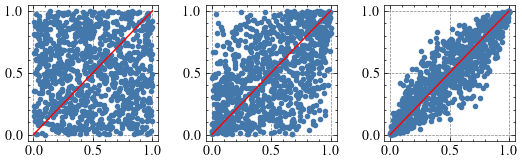

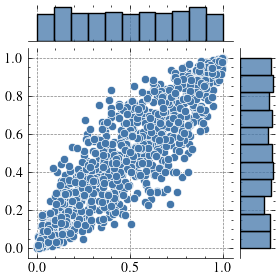

In [11]:
x1, y1 = gen_data_1d(corr=0.0, n=1000, plotting=False, dist='uniform')
corr1 = pearsonr(x1, y1)[0]
print("Correlation:", corr1)

x2, y2 = gen_data_1d(corr=0.5, n=1000, plotting=False, dist='uniform')
corr2 = pearsonr(x2, y2)[0]
print("Correlation:", corr2)

x3, y3 = gen_data_1d(corr=0.9, n=1000, plotting=False, dist='uniform')
corr3 = pearsonr(x3, y3)[0]
print("Correlation:", corr3)

plt.figure(figsize=(figwidth_thesis, figwidth_thesis/3))
plt.subplot(1, 3, 1)
plt.scatter(x1, y1, marker='.')
plt.plot([0, 1], [0, 1], 'red')

plt.subplot(1, 3, 2)
plt.scatter(x2, y2, marker='.')
plt.plot([0, 1], [0, 1], 'red')

plt.subplot(1, 3, 3)
plt.scatter(x3, y3, marker='.')
plt.plot([0, 1], [0, 1], 'red')

plt.tight_layout()
plt.savefig("gen_uniform_data.png", dpi=dpi_thesis)

sns.jointplot(x=x3, y=y3, height=3)
plt.savefig("gen_uniform_joint.png", dpi=dpi_thesis)
print("Pearson correlation:", pearsonr(x3, y3))
print("Kolmogorov-Smirnov test, uniform:", kstest(x3, 'uniform'))
print("Kolmogorov-Smirnov test, uniform:", kstest(y3, 'uniform'))

Marginal distributions

Correlation: -0.0002971846479601255
Correlation: 0.5054247989950917
Correlation: 0.89612585754861


C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


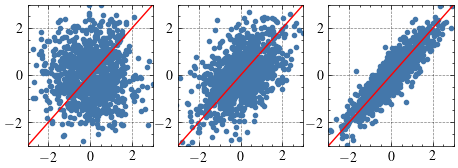

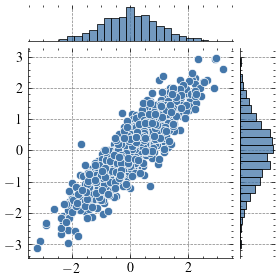

In [12]:
x1, y1 = gen_data_1d(corr=0.0, n=1000, plotting=False, dist='normal')
corr1 = pearsonr(x1, y1)[0]
print("Correlation:", corr1)

x2, y2 = gen_data_1d(corr=0.5, n=1000, plotting=False, dist='normal')
corr2 = pearsonr(x2, y2)[0]
print("Correlation:", corr2)

x3, y3 = gen_data_1d(corr=0.9, n=1000, plotting=False, dist='normal')
corr3 = pearsonr(x3, y3)[0]
print("Correlation:", corr3)

plt.figure(figsize=(figwidth_thesis, figwidth_thesis/3))
plt.subplot(1, 3, 1)
plt.scatter(x1, y1, marker='.')
plt.plot([-3, 3], [-3, 3], 'red')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.subplot(1, 3, 2)
plt.scatter(x2, y2, marker='.')
plt.plot([-3, 3], [-3, 3], 'red')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.subplot(1, 3, 3)
plt.scatter(x3, y3, marker = '.')
plt.plot([-3, 3], [-3, 3], 'red')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.savefig("gen_normal_data.png", dpi=dpi_thesis)

sns.jointplot(x=x3, y=y3, height=3)
plt.savefig("gen_normal_distr.png", dpi=dpi_thesis)

In [13]:
print(kstest(x3, 'norm'))
print(kstest(y3, 'norm'))
print("p-values are much higher than 0.01, therefore both array are indeed distributed normally")

KstestResult(statistic=0.01863994020740467, pvalue=0.8713371940926317, statistic_location=0.7171527012219213, statistic_sign=1)
KstestResult(statistic=0.01921891207363302, pvalue=0.8467215176788584, statistic_location=0.8021990529170441, statistic_sign=1)
p-values are much higher than 0.01, therefore both array are indeed distributed normally


Bimodal distribution

Correlation (target): 0.0
Correlation (actual): -0.04578317608790865
Correlation (target): 0.7
Correlation (actual): 0.7096766697206719
Correlation (target): 0.95
Correlation (actual): 0.9355106611493411


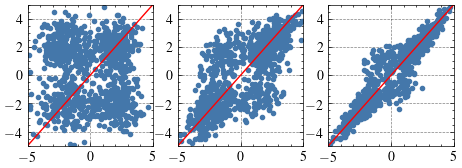

In [14]:
corr1_target = 0.0
x1, y1 = gen_data_1d(corr=corr1_target, n=1000, plotting=False, dist='bimodal')
corr1 = pearsonr(x1, y1)[0]
print("Correlation (target):", corr1_target)
print("Correlation (actual):", corr1)

corr2_target = 0.7
x2, y2 = gen_data_1d(corr=corr2_target, n=1000, plotting=False, dist='bimodal')
corr2 = pearsonr(x2, y2)[0]
print("Correlation (target):", corr2_target)
print("Correlation (actual):", corr2)

corr3_target = 0.95
x3, y3 = gen_data_1d(corr=corr3_target, n=1000, plotting=False, dist='bimodal')
corr3 = pearsonr(x3, y3)[0]
print("Correlation (target):", corr3_target)
print("Correlation (actual):", corr3)

plt.figure(figsize=(figwidth_thesis, figwidth_thesis/3))
plt.subplot(1, 3, 1)
plt.scatter(x1, y1, marker='.')
plot_lim = 5
plt.plot([-plot_lim, plot_lim], [-plot_lim, plot_lim], 'red')
plt.xlim(-plot_lim, plot_lim)
plt.ylim(-plot_lim, plot_lim)
plt.subplot(1, 3, 2)
plt.scatter(x2, y2, marker='.')
plt.plot([-plot_lim, plot_lim], [-plot_lim, plot_lim], 'red')
plt.xlim(-plot_lim, plot_lim)
plt.ylim(-plot_lim, plot_lim)
plt.subplot(1, 3, 3)
plt.scatter(x3, y3, marker='.')
plt.plot([-plot_lim, plot_lim], [-plot_lim, plot_lim], 'red')
plt.xlim(-plot_lim, plot_lim)
plt.ylim(-plot_lim, plot_lim)

plt.savefig("gen_bimodal_data.png", dpi=600)

C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


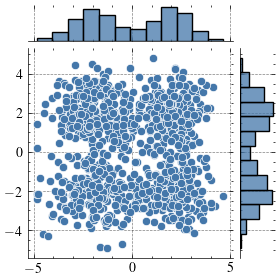

C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 350x262.5 with 0 Axes>

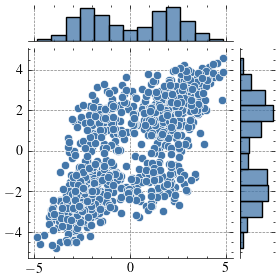

C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Saveliy\anaconda3\envs\general\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


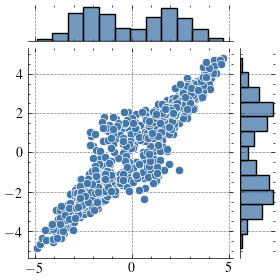

<Figure size 350x262.5 with 0 Axes>

In [15]:
sns.jointplot(x=x1, y=y1, height=3)
plt.show()
plt.savefig("gen_bimodal_distr_1.png", dpi=dpi_thesis)
sns.jointplot(x=x2, y=y2, height=3)
plt.show()
sns.jointplot(x=x3, y=y3, height=3)
plt.show()
plt.savefig("gen_bimodal_distr_2.png", dpi=dpi_thesis)

In [16]:
kstest(x3, binormal_cdf, args=(mu, sigma, alpha,))

KstestResult(statistic=0.026208308882937348, pvalue=0.48994935937911077, statistic_location=0.26474268604397366, statistic_sign=1)

Let's test how closely correlation in generated data matches desired correlation.

In [17]:
def plot_gen_hist(arr_1, arr_2, arr_3):
    plt.figure(figsize=(figwidth_thesis, figheight_thesis/3))
    plt.hist(arr_1, label='$\\rho=0$')
    plt.plot([0, 0], [0, 200], 'darkred')
    plt.hist(arr_2, label='$\\rho=0.5$')
    plt.plot([0.5, 0.5], [0, 200], 'darkred')
    plt.hist(arr_3, label='$\\rho=0.9$')
    plt.plot([0.9, 0.9], [0, 200], 'darkred')
    plt.legend(loc='upper left')
    plt.xlim(-0.4, 1.0)
    plt.ylim(0, 200)

n_exp = 5000      # number of experiments (pairs of points: desired corr - actual corr)
n_points = 500    # number of generated points on each generator launch
corr_1 = 0.0
corr_2 = 0.5
corr_3 = 0.9

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 187.39it/s]


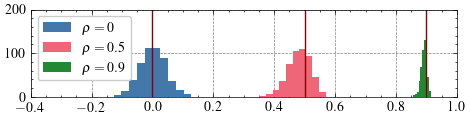

In [18]:
arr_1 = np.zeros(n_points)
arr_2 = np.zeros(n_points)
arr_3 = np.zeros(n_points)

for i in tqdm(range(n_points)):
    x, y = gen_data_1d(corr=corr_1, n=n_points, plotting=False, dist='uniform')
    corr_pearson = pearsonr(x, y)[0]
    arr_1[i] = corr_pearson
    
    x, y = gen_data_1d(corr=corr_2, n=n_points, plotting=False, dist='uniform')
    corr_pearson = pearsonr(x, y)[0]
    arr_2[i] = corr_pearson
    
    x, y = gen_data_1d(corr=corr_3, n=n_points, plotting=False, dist='uniform')
    corr_pearson = pearsonr(x, y)[0]
    arr_3[i] = corr_pearson

plot_gen_hist(arr_1, arr_2, arr_3)

plt.savefig("generator_hist_uniform.png", dpi=dpi_thesis)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 265.20it/s]


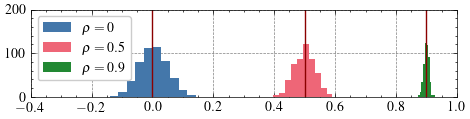

In [19]:
arr_1 = np.zeros(n_points)
arr_2 = np.zeros(n_points)
arr_3 = np.zeros(n_points)

for i in tqdm(range(n_points)):
    x, y = gen_data_1d(corr=corr_1, n=n_points, plotting=False, dist='normal')
    corr_pearson = pearsonr(x, y)[0]
    arr_1[i] = corr_pearson
    
    x, y = gen_data_1d(corr=corr_2, n=n_points, plotting=False, dist='normal')
    corr_pearson = pearsonr(x, y)[0]
    arr_2[i] = corr_pearson
    
    x, y = gen_data_1d(corr=corr_3, n=n_points, plotting=False, dist='normal')
    corr_pearson = pearsonr(x, y)[0]
    arr_3[i] = corr_pearson

plot_gen_hist(arr_1, arr_2, arr_3)

plt.savefig("generator_hist_normal.png", dpi=dpi_thesis)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 34.99it/s]


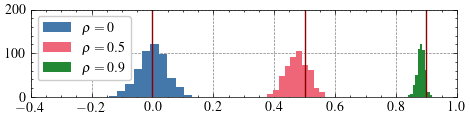

In [20]:
arr_1 = np.zeros(n_points)
arr_2 = np.zeros(n_points)
arr_3 = np.zeros(n_points)

for i in tqdm(range(n_points)):
    x, y = gen_data_1d(corr=corr_1, n=n_points, plotting=False, dist='bimodal')
    corr_pearson = pearsonr(x, y)[0]
    arr_1[i] = corr_pearson
    
    x, y = gen_data_1d(corr=corr_2, n=n_points, plotting=False, dist='bimodal')
    corr_pearson = pearsonr(x, y)[0]
    arr_2[i] = corr_pearson
    
    x, y = gen_data_1d(corr=corr_3, n=n_points, plotting=False, dist='bimodal')
    corr_pearson = pearsonr(x, y)[0]
    arr_3[i] = corr_pearson

plot_gen_hist(arr_1, arr_2, arr_3)

plt.savefig("generator_hist_bimodal.png", dpi=dpi_thesis)

An actual correlation of generated sample seems to be normally distributed near desired correlation. It also seems that variance depends on the desired correlation value.

In [21]:
n_repetitions = 400

arr_desired_corr = np.arange(0, 1.1, 0.1)
arr_real_corr_uniform = np.zeros_like(arr_desired_corr)
arr_real_corr_normal = np.zeros_like(arr_desired_corr)
arr_real_corr_bimodal = np.zeros_like(arr_desired_corr)

for i in tqdm(range(len(arr_desired_corr))):
    avg_real_corr_uniform = 0
    avg_real_corr_normal = 0
    avg_real_corr_bimodal = 0
    for j in range(n_repetitions):
        x, y = gen_data_1d(corr=arr_desired_corr[i], n=500, plotting=False, dist='uniform')
        avg_real_corr_uniform += pearsonr(x, y)[0]
        x, y = gen_data_1d(corr=arr_desired_corr[i], n=500, plotting=False, dist='normal')
        avg_real_corr_normal += pearsonr(x, y)[0]
        x, y = gen_data_1d(corr=arr_desired_corr[i], n=500, plotting=False, dist='bimodal')
        avg_real_corr_bimodal += pearsonr(x, y)[0]
    avg_real_corr_uniform /= n_repetitions
    avg_real_corr_normal /= n_repetitions
    avg_real_corr_bimodal /= n_repetitions
    arr_real_corr_uniform[i] = avg_real_corr_uniform
    arr_real_corr_normal[i] = avg_real_corr_normal
    arr_real_corr_bimodal[i] = avg_real_corr_bimodal

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:51<00:00,  4.69s/it]


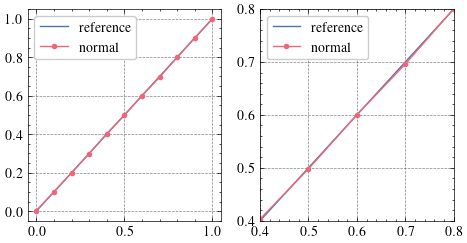

In [22]:
plt.figure(figsize=(figwidth_thesis, figwidth_thesis/2))
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], label='reference')
plt.plot(arr_desired_corr, arr_real_corr_normal, '.-', label='normal')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], label='reference')
plt.plot(arr_desired_corr, arr_real_corr_normal, '.-', label='normal')
plt.xlim([0.4, 0.8])
plt.ylim([0.4, 0.8])
plt.legend()
plt.savefig("generator_corr_comparison_normal.png", dpi=dpi_thesis)

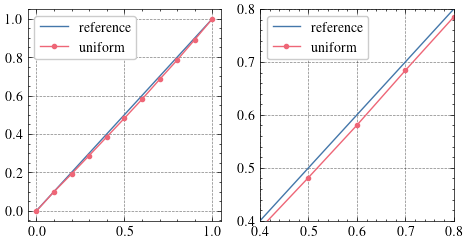

In [23]:
plt.figure(figsize=(figwidth_thesis, figwidth_thesis/2))
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], label='reference')
plt.plot(arr_desired_corr, arr_real_corr_uniform, '.-', label='uniform')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], label='reference')
plt.plot(arr_desired_corr, arr_real_corr_uniform, '.-', label='uniform')
plt.xlim([0.4, 0.8])
plt.ylim([0.4, 0.8])
plt.legend()
plt.savefig("generator_corr_comparison_uniform.png", dpi=dpi_thesis)

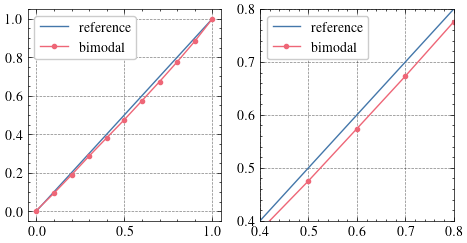

In [24]:
plt.figure(figsize=(figwidth_thesis, figwidth_thesis/2))
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], label='reference')
plt.plot(arr_desired_corr, arr_real_corr_bimodal, '.-', label='bimodal')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], label='reference')
plt.plot(arr_desired_corr, arr_real_corr_bimodal, '.-', label='bimodal')
plt.xlim([0.4, 0.8])
plt.ylim([0.4, 0.8])
plt.legend()
plt.savefig("generator_corr_comparison_bimodal.png", dpi=dpi_thesis)

### 1.2. Generation of N-dim data

To generate N-dimensional data, we simply generate N samples and stack marginals together.

In [25]:
def gen_data(corr = 0.5, n = 50, plotting=False, dist='uniform', dims=2):
    """
    Generate initial data.
    
    Generates two N-dimensional arrays of data with given correlation 
    for each dimension (or rather, close to it) and with given length.
    """
    
    assert corr >= -1.0 and corr <= 1.0
    assert n > 0
    assert dist in ['uniform', 'normal', 'bimodal']
    assert dims >= 1
    
    # Placeholder for generated data
    # e.g. 50 points, 3 dimensions gives us 50x3 array
    x = np.zeros(shape=(n, dims))
    y = np.zeros(shape=(n, dims))
    
    # Generate a pair of 1D-arrays for each dimension
    for d in range(dims):
        res_1d = gen_data_1d(corr=corr, n=n, plotting=False, dist=dist)
        x[:,d] = res_1d[0]
        y[:,d] = res_1d[1]
    
    return (x, y)

Additionaly, let's define a function to make "Y vs X" for a pair of multi-dimensional arrays.

In [26]:
def plot_data_two_arrays(x, y):
    """
    Plots two multi-dimensional arrays of generated data against each other.
    If there are strong correlations in data, we can see them on the plot.
    """
    
    assert x.shape == y.shape
    
    # If 1-D array, call corresponding function
    if len(x.shape) == 1:
        plt.figure(figsize=(4, 4))
        plt.scatter(x, y)
        plt.title("Y vs X")
        return
    
    if x.shape[1] > 4:
        print("Number of dimensions is too high, plotting first 4 dimensions...")
    
    plt.figure(figsize=(15, 3))
    for i in range(min(x.shape[1], 4)):
        plt.subplot(1, 4, i+1)
        plt.scatter(x[:,i], y[:,i])
        plt.title("Y vs X, dim:"+str(i))

After generating a pair of multi-dimensional arrays, we can compare each dimension separately and check the degree of correlation.

Correlation: 0.8859707799206837


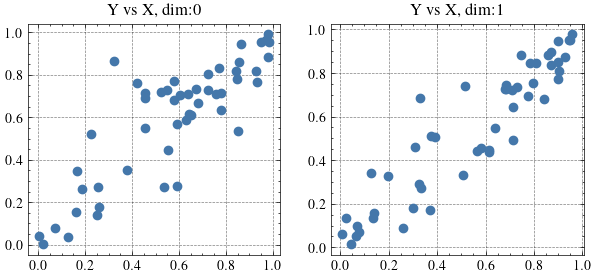

In [27]:
x, y = gen_data(corr = 0.9, n = 50, plotting=False, dist='uniform', dims=2)

plot_data_two_arrays(x, y)

# Stack each component on top of each other then calcualte correlation
corr = pearsonr(x.flatten(), y.flatten())[0]
print("Correlation:", corr)

## 2. Applying RSA

Second part is applying RSA itself. After we have some data, whether it's generated or real data, we need to apply RSA. This section explains some steps to perform RSA on two sequences of data and provides code to implement the required functions.

### 2.1. Calculating RDMs

One particular challenge is using geodesic graph distance. For that, we need to build a graph.

In [28]:
def build_graph_from_array(arr, k):
    """
    Create a graph from array of points. Each point is connected to K nearest neighbors, where K is given as a parameter.
    
    Returns a matrix, where both dimensions are equal to the number of points.
    If two vertices aren't connected, corresponding place in matrix is -1. If they are connected, number is equal to 
    Euclidean distance between points. Distance from a point to itself is equal to 0.
    """
    
    n = arr.shape[0]
    dims = arr.shape[1]
    
    # Placeholder for connections and weights
    g = np.ones((n, n)) * np.inf
    
    # Calculate Euclidean distances between each pair of points
    dists = np.copy(g)
    for i in range(n):
        for j in range(n):
            d = np.sqrt(np.sum((arr[i,:] - arr[j,:]) ** 2))
            dists[i,j] = d
    
    # Connect each vertex to K nearest-neighbour vertices
    for i in range(n): # source
        arr_val_min = []
        arr_ind_min = []
        for j in range(k + 1): # plus one to connect vertex to itself in the same cycle
            min_value = np.min(dists[i])
            min_ind = np.argmin(dists[i])
            dists[i,min_ind] = np.inf # exclude vertex from futher search (for given source vertex)
            arr_val_min.append(min_value)
            arr_ind_min.append(min_ind)
        
        # Connect nearest neighbors
        for j in range(len(arr_ind_min)):
            g[i,arr_ind_min[j]] = arr_val_min[j]
    
    return g

In [29]:
def calc_geodesic_distances_graph(g):
    """
    Calculates geodesic distances between each pair of points in a graph.
    """
    
    n = g.shape[0]
    
    # Placeholder for the result
    dists = np.copy(g)
    
    # Apply the algorithm (Floyd-Warshall?)
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if dists[i][k] + dists[k][j] < dists[i][j]:
                    dists[i][j] = dists[i][k] + dists[k][j]
    
    return dists

Function for RDM calculation

In [30]:
def calc_rdm(x, method='euclidean'):
    """
    Calculate RDM for given array.
    """
    
    assert method in ['euclidean', 'cosine', 'geodesic']
    assert len(x.shape) == 1 or len(x.shape) == 2
    
    # Check if x is 1-dimensional and convert to 2-D if so (i.e. vector of length N -> array of size (1,N))
    if len(x.shape) == 1:
        x = x.reshape((1,-1))
    
    # Remember number of points and number of dimensions
    n = x.shape[0]
    dims = x.shape[1]
    
    # Placeholder for RDM
    rdm = np.zeros((n, n))
    
    # Special treatment for geodesic distance
    if method == 'geodesic':
        # Here K is fixed, but TODO: it probably should be possible to set K when calling the RDM function
        k = 4
        g = build_graph_from_array(x, k)
        dists = calc_geodesic_distances_graph(g)
        rdm = dists
    else:
        # For each pair of points
        for i in range(n):
            point_1 = x[i, :]
            for j in range(n):
                point_2 = x[j, :]

                # Euclidean distance
                diss = None
                if method == 'euclidean':
                    diss = np.sqrt( np.sum((point_1 - point_2)**2) )
                elif method == 'cosine':
                    sim = np.sum(point_1 * point_2) / (np.sqrt(np.sum(point_1**2)) * np.sqrt(np.sum(point_2**2)))
                    diss = 1 - sim
                else:
                    raise RuntimeError("Distance method \"" + method + "\" is not supported.")

                rdm[i, j] = diss
    
    return rdm

## 3. Tying everything together

### 3.1. Combining data generation and RSA

End-to-end function for one experiment. Returns a pair of values: correlation in underlying data and correlation in processed data.

In [31]:
def generate(corr = 0.7, n = 50, dims=1, plotting=False, dist='uniform', diss='euclidean'):
    """
    This function makes the following:
    1. Generates two 1-D arrays of data with given correlation (or rather, close to it) and length;
    2. Builds RDMs from generated arrays;
    3. Calculates and returns Pearson correlation between initial arrays and Kendall correlation between RDMs.
    """
    
    assert corr >= -1.0 and corr <= 1.0
    assert n > 0
    assert dims > 0
    assert dist in ['uniform', 'normal', 'bimodal']
    assert diss in ['euclidean', 'cosine', 'geodesic']

    # Generate two arrays of correlated data
    x, y = gen_data(corr=corr, n=n, plotting=plotting, dist=dist, dims=dims)
    
    # Calculate Pearson correlation coefficient
    (corr_pearson, p_val_pearson) = pearsonr(x.flatten(), y.flatten())

    # Create RDMs
    matr_x = calc_rdm(x, diss)
    matr_y = calc_rdm(y, diss)

    # Visualize RDMs as heatmaps
    if plotting == True:
        plt.subplot(1, 3, 2)
        plt.imshow(matr_x)
        plt.title("RDM X")
        plt.subplot(1, 3, 3)
        plt.imshow(matr_y)
        plt.title("RDM Y")
    
    #corr_kendall_matr = kendalltau(matr_x.flatten(), matr_y.flatten())
    (corr_kendall_matr, p_val_kendall_matr) = kendalltau(matr_x, matr_y)

    # Output results
    #print("Pearson X, Y:", corr_pearson)
    #print("Kendall RDM_X, RDM_Y:", corr_kendall_matr)
    
    res = {
        "corr_pearson" : corr_pearson,
        "p_val_pearson" : p_val_pearson,
        "corr_kendall_matr" : corr_kendall_matr,
        "p_val_kendall_matr" : p_val_kendall_matr
    }
    
    return res

Make an experiment and check the results

{'corr_pearson': 0.4394710220026778,
 'p_val_pearson': 0.001407519420133165,
 'corr_kendall_matr': 0.09380834908531702,
 'p_val_kendall_matr': 2.1367883881686436e-12}

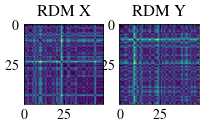

In [32]:
generate(0.5, 50, dims=1, plotting=True, dist='normal', diss='euclidean')

### 3.2. Simulating a series of experiements

Let's use the last defined function to simulate a series of experiments where we recieve two arrays of predefined length (e.g. show two sets of 50 images each to 200 people), while varying correlation between the arrays.

<font color='red'>Todo - make function that outputs Pearson correlations in input data and corresponding Kendall-tau correlations in output data</font>

In [33]:
def do_experiments(
    n_points = 50,
    dims = 1,
    dist='normal',
    diss='euclidean'
):
    """
    Generates several sequences of data with various correlation and performs RSA on each sequence.
    
    Generated arrays have varying correlation from -1 to 1 with step 0.02.
    
    Outputs arrays of correlations in initial data and array of correlations between RDMs that we get from processed data.
    """

    # Amount of X values on a graph
    n_pearson_values = 21

    # Amount of performing generation + RSA for each value of X
    n_repetitions = 5
    
    # Placeholders for Pearson and Kendall-tau correlations
    arr_x = np.zeros(n_pearson_values)
    arr_y = np.zeros(n_pearson_values)
    
    # Calculations for each desired value of Pearson's correlation
    for i in tqdm(range(n_pearson_values)):
        corr = 0.1 * i - 1
        avg_corr_pearson = 0
        avg_kendall_matr = 0
        for j in range(n_repetitions):
            res = generate(corr=corr, n=n_points, dims=dims, plotting=False, dist=dist, diss=diss)
            corr_pearson = res['corr_pearson']
            corr_kendall_matr = res['corr_kendall_matr']
            avg_corr_pearson += corr_pearson
            avg_kendall_matr += corr_kendall_matr
        avg_corr_pearson /= n_repetitions
        avg_kendall_matr /= n_repetitions
        arr_x[i] = avg_corr_pearson
        arr_y[i] = avg_kendall_matr
    
    return arr_x, arr_y

In [34]:
def plot_corr_in_out(arr_x, arr_y):
    """
    Plots correlations in RDMs against correlations in input data.
    """
    
    # Plot the results
    plt.figure(figsize=(figwidth_thesis, figheight_thesis))
    plt.scatter(arr_x, arr_y)
    #title_text = "Kendall vs Pearson"
    #plt.title(title_text)
    plt.grid()
    plt.plot([-1, 1], [-1, 1], color='red')
    plt.xlabel("Correlation in initial data (Pearson)")
    plt.ylabel("Correlation between RDMs (Kendall)")
    
    # Hypothesis
    #x_hyp = np.arange(-1, 1, 0.01)
    #y_hyp = 2 * x_hyp / np.sqrt(1 + 3 * x_hyp ** 2)
    #plt.plot(x_hyp, y_hyp, 'g--')
    
    plt.legend(["Result", "Reference"])
    plt.grid()

#### 3.2.1. Uniform distribution + Euclidean distance (various dimensions)

First plot shows only 1-D sequence.

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.09s/it]


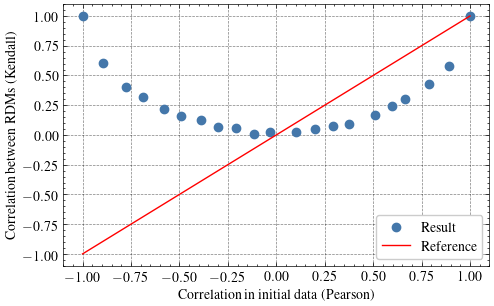

In [35]:
# Generate several experiments
n_points = 100
dims = 10
dist = 'uniform'
diss = 'euclidean'

arr_x, arr_y = do_experiments(n_points=n_points, dims=dims, dist=dist, diss=diss)
plot_corr_in_out(arr_x, arr_y)

Plot with various dimensions.

In [36]:
n_points = 50
dist = 'uniform'
diss = 'euclidean'

arr_x1, arr_y1 = do_experiments(n_points=n_points, dims=1, dist=dist, diss=diss)
arr_x2, arr_y2 = do_experiments(n_points=n_points, dims=5, dist=dist, diss=diss)
#arr_x3, arr_y3 = do_experiments(n_points=n_points, dims=20, dist=dist, diss=diss)
arr_x4, arr_y4 = do_experiments(n_points=n_points, dims=100, dist=dist, diss=diss)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:11<00:00,  1.79it/s]


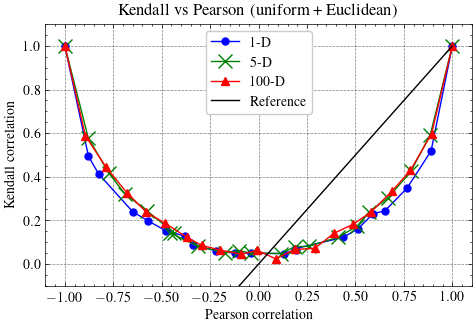

In [37]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
title_text = "Kendall vs Pearson (uniform + Euclidean)"
plt.title(title_text)
plt.grid()
plt.xlabel("Pearson correlation")
plt.ylabel("Kendall correlation")
plt.plot(arr_x1, arr_y1, 'b.-', markersize=10)
plt.plot(arr_x2, arr_y2, 'gx-', markersize=10)
#plt.plot(arr_x3, arr_y3, 'm.')
plt.plot(arr_x4, arr_y4, 'r^-')
plt.plot([-1, 1], [-1, 1], color='black')

plt.legend(["1-D", "5-D", "100-D", "Reference"], loc='upper center')
plt.grid()
plt.ylim(-0.1, 1.1)

plt.savefig("result_uniform_euclidean.png", dpi=dpi_thesis)
plt.show()

#### 3.2.2. Normal distribution + Euclidean distance (various dimensions)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.05s/it]


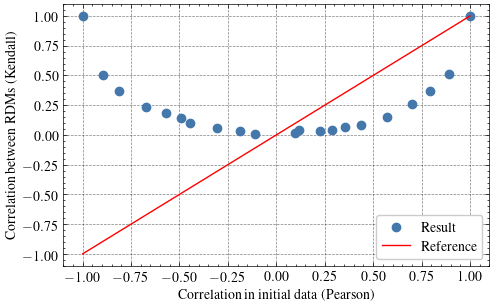

In [38]:
# Generate several experiments
n_points = 100
dims = 1
dist = 'normal'
diss = 'euclidean'

arr_x, arr_y = do_experiments(n_points=n_points, dims=dims, dist=dist, diss=diss)
plot_corr_in_out(arr_x, arr_y)

In [39]:
n_points = 50
dist = 'normal'
diss = 'euclidean'

arr_x1, arr_y1 = do_experiments(n_points=n_points, dims=1, dist=dist, diss=diss)
arr_x2, arr_y2 = do_experiments(n_points=n_points, dims=5, dist=dist, diss=diss)
#arr_x3, arr_y3 = do_experiments(n_points=n_points, dims=20, dist=dist, diss=diss)
arr_x4, arr_y4 = do_experiments(n_points=n_points, dims=100, dist=dist, diss=diss)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.85it/s]


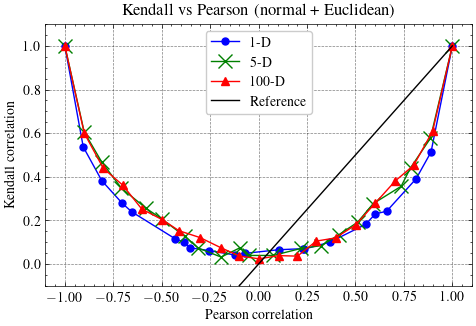

In [40]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
title_text = "Kendall vs Pearson (normal + Euclidean)"
plt.title(title_text)
plt.grid()
plt.xlabel("Pearson correlation")
plt.ylabel("Kendall correlation")
plt.plot(arr_x1, arr_y1, 'b.-', markersize=10)
plt.plot(arr_x2, arr_y2, 'gx-', markersize=10)
#plt.plot(arr_x3, arr_y3, 'm.')
plt.plot(arr_x4, arr_y4, 'r^-')
plt.plot([-1, 1], [-1, 1], color='black')

plt.legend(["1-D", "5-D", "100-D", "Reference"], loc='upper center')
plt.grid()
plt.ylim(-0.1, 1.1)

plt.savefig("result_normal_euclidean.png", dpi=dpi_thesis)
plt.show()

#### 3.2.3. Bimodal distribution + Euclidean distance (various dimensions)

In [41]:
n_points = 50
dist = 'bimodal'
diss = 'euclidean'

arr_x1, arr_y1 = do_experiments(n_points=n_points, dims=1, dist=dist, diss=diss)
arr_x2, arr_y2 = do_experiments(n_points=n_points, dims=5, dist=dist, diss=diss)
#arr_x3, arr_y3 = do_experiments(n_points=n_points, dims=20, dist=dist, diss=diss)
arr_x4, arr_y4 = do_experiments(n_points=n_points, dims=100, dist=dist, diss=diss)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.08it/s]


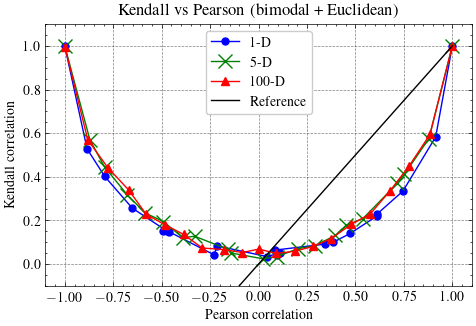

In [42]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
title_text = "Kendall vs Pearson (bimodal + Euclidean)"
plt.title(title_text)
plt.grid()
plt.xlabel("Pearson correlation")
plt.ylabel("Kendall correlation")
plt.plot(arr_x1, arr_y1, 'b.-', markersize=10)
plt.plot(arr_x2, arr_y2, 'gx-', markersize=10)
#plt.plot(arr_x3, arr_y3, 'm.')
plt.plot(arr_x4, arr_y4, 'r^-')
plt.plot([-1, 1], [-1, 1], color='black')

plt.legend(["1-D", "5-D", "100-D", "Reference"], loc='upper center')
plt.grid()
plt.ylim(-0.1, 1.1)

plt.savefig("result_bimodal_euclidean.png", dpi=dpi_thesis)
plt.show()

#### 3.2.4. Uniform distribution + cosine distance (various dimensions)

In [43]:
n_points = 50
dist = 'uniform'
diss = 'cosine'

arr_x1, arr_y1 = do_experiments(n_points=n_points, dims=2, dist=dist, diss=diss)
arr_x2, arr_y2 = do_experiments(n_points=n_points, dims=5, dist=dist, diss=diss)
#arr_x3, arr_y3 = do_experiments(n_points=n_points, dims=20, dist=dist, diss=diss)
arr_x4, arr_y4 = do_experiments(n_points=n_points, dims=100, dist=dist, diss=diss)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.09it/s]


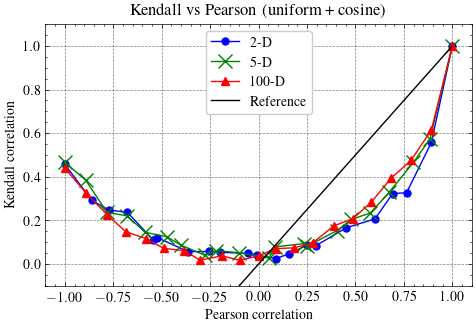

In [44]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
title_text = "Kendall vs Pearson (uniform + cosine)"
plt.title(title_text)
plt.grid()
plt.xlabel("Pearson correlation")
plt.ylabel("Kendall correlation")
plt.plot(arr_x1, arr_y1, 'b.-', markersize=10)
plt.plot(arr_x2, arr_y2, 'gx-', markersize=10)
#plt.plot(arr_x3, arr_y3, 'm.')
plt.plot(arr_x4, arr_y4, 'r^-')
plt.plot([-1, 1], [-1, 1], color='black')

plt.legend(["2-D", "5-D", "100-D", "Reference"], loc='upper center')
plt.grid()
plt.ylim(-0.1, 1.1)

plt.savefig("result_uniform_cosine.png", dpi=dpi_thesis)
plt.show()

#### 3.2.5. Normal distribution + cosine distance (various dimensions)

In [45]:
n_points = 50
dist = 'normal'
diss = 'cosine'

arr_x1, arr_y1 = do_experiments(n_points=n_points, dims=2, dist=dist, diss=diss)
arr_x2, arr_y2 = do_experiments(n_points=n_points, dims=5, dist=dist, diss=diss)
#arr_x3, arr_y3 = do_experiments(n_points=n_points, dims=20, dist=dist, diss=diss)
arr_x4, arr_y4 = do_experiments(n_points=n_points, dims=100, dist=dist, diss=diss)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.41it/s]


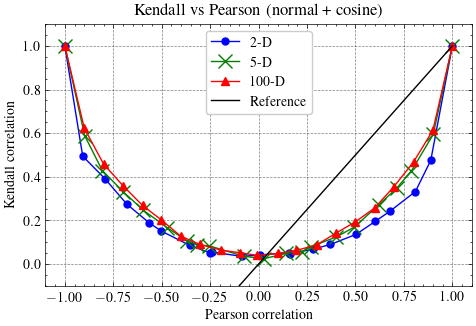

In [46]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
title_text = "Kendall vs Pearson (normal + cosine)"
plt.title(title_text)
plt.grid()
plt.xlabel("Pearson correlation")
plt.ylabel("Kendall correlation")
plt.plot(arr_x1, arr_y1, 'b.-', markersize=10)
plt.plot(arr_x2, arr_y2, 'gx-', markersize=10)
#plt.plot(arr_x3, arr_y3, 'm.')
plt.plot(arr_x4, arr_y4, 'r^-')
plt.plot([-1, 1], [-1, 1], color='black')

plt.legend(["2-D", "5-D", "100-D", "Reference"], loc='upper center')
plt.grid()
plt.ylim(-0.1, 1.1)

plt.savefig("result_normal_cosine.png", dpi=dpi_thesis)
plt.show()

#### 3.2.6. Bimodal distribution + cosine distance (various dimensions)

In [47]:
n_points = 50
dist = 'bimodal'
diss = 'cosine'

arr_x1, arr_y1 = do_experiments(n_points=n_points, dims=2, dist=dist, diss=diss)
arr_x2, arr_y2 = do_experiments(n_points=n_points, dims=5, dist=dist, diss=diss)
#arr_x3, arr_y3 = do_experiments(n_points=n_points, dims=20, dist=dist, diss=diss)
arr_x4, arr_y4 = do_experiments(n_points=n_points, dims=100, dist=dist, diss=diss)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.29s/it]


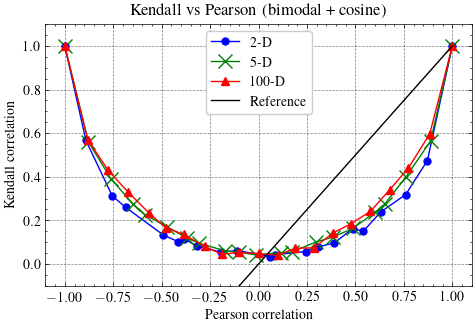

In [48]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
title_text = "Kendall vs Pearson (bimodal + cosine)"
plt.title(title_text)
plt.grid()
plt.xlabel("Pearson correlation")
plt.ylabel("Kendall correlation")
plt.plot(arr_x1, arr_y1, 'b.-', markersize=10)
plt.plot(arr_x2, arr_y2, 'gx-', markersize=10)
#plt.plot(arr_x3, arr_y3, 'm.')
plt.plot(arr_x4, arr_y4, 'r^-')
plt.plot([-1, 1], [-1, 1], color='black')

plt.legend(["2-D", "5-D", "100-D", "Reference"], loc='upper center')
plt.grid()
plt.ylim(-0.1, 1.1)

plt.savefig("result_bimodal_cosine.png", dpi=dpi_thesis)
plt.show()

#### 3.2.7. Euclidean distance + 10 dimensions (uniform vs normal vs bimodal)

In [49]:
n_points = 50
dims = 10
diss = 'euclidean'
dist = -1

arr_x1, arr_y1 = do_experiments(n_points=n_points, dims=dims, dist='uniform', diss=diss)
arr_x2, arr_y2 = do_experiments(n_points=n_points, dims=dims, dist='normal', diss=diss)
#arr_x3, arr_y3 = do_experiments(n_points=n_points, dims=20, dist=dist, diss=diss)
arr_x4, arr_y4 = do_experiments(n_points=n_points, dims=dims, dist='bimodal', diss=diss)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.97it/s]


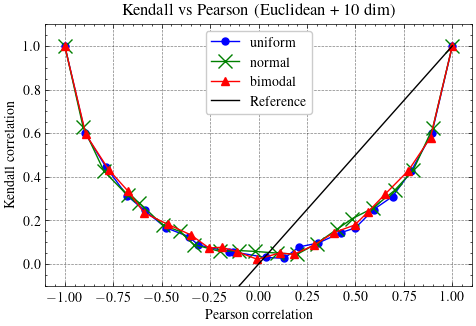

In [50]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
title_text = "Kendall vs Pearson (Euclidean + 10 dim)"
plt.title(title_text)
plt.grid()
plt.xlabel("Pearson correlation")
plt.ylabel("Kendall correlation")
plt.plot(arr_x1, arr_y1, 'b.-', markersize=10)
plt.plot(arr_x2, arr_y2, 'gx-', markersize=10)
#plt.plot(arr_x3, arr_y3, 'm.')
plt.plot(arr_x4, arr_y4, 'r^-')
plt.plot([-1, 1], [-1, 1], color='black')

plt.legend(["uniform", "normal", "bimodal", "Reference"], loc='upper center')
plt.grid()
plt.ylim(-0.1, 1.1)

plt.savefig("result_euclidean_10D.png", dpi=dpi_thesis)
plt.show()

#### 3.2.8. Cosine distance + 10 dimensions (uniform vs normal vs bimodal)

In [51]:
n_points = 50
dims = 10
diss = 'cosine'
dist = -1

arr_x1, arr_y1 = do_experiments(n_points=n_points, dims=dims, dist='uniform', diss=diss)
arr_x2, arr_y2 = do_experiments(n_points=n_points, dims=dims, dist='normal', diss=diss)
arr_x3, arr_y3 = do_experiments(n_points=n_points, dims=dims, dist='bimodal', diss=diss)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.42it/s]


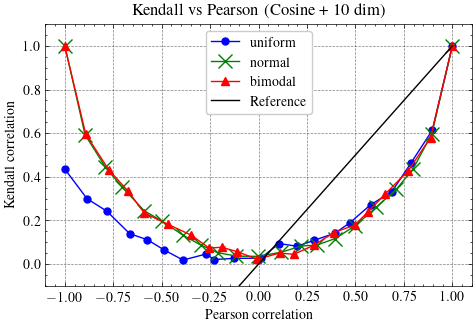

In [52]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
title_text = "Kendall vs Pearson (Cosine + 10 dim)"
plt.title(title_text)
plt.grid()
plt.xlabel("Pearson correlation")
plt.ylabel("Kendall correlation")
plt.plot(arr_x1, arr_y1, 'b.-', markersize=10)
plt.plot(arr_x2, arr_y2, 'gx-', markersize=10)
#plt.plot(arr_x3, arr_y3, 'm.')
plt.plot(arr_x4, arr_y4, 'r^-')
plt.plot([-1, 1], [-1, 1], color='black')

plt.legend(["uniform", "normal", "bimodal", "Reference"], loc='upper center')
plt.grid()
plt.ylim(-0.1, 1.1)

plt.savefig("result_cosine_10D.png", dpi=dpi_thesis)
plt.show()

#### 3.2.9. Normal distribution + 10 dimensionss (Euclidean vs cosine vs graph)

In [53]:
n_points = 50
dims = 10
dist = 'normal'
diss = -1

arr_x1, arr_y1 = do_experiments(n_points=n_points, dims=dims, dist=dist, diss='euclidean')
arr_x2, arr_y2 = do_experiments(n_points=n_points, dims=dims, dist=dist, diss='cosine')
arr_x3, arr_y3 = do_experiments(n_points=n_points, dims=dims, dist=dist, diss='geodesic')

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.41s/it]


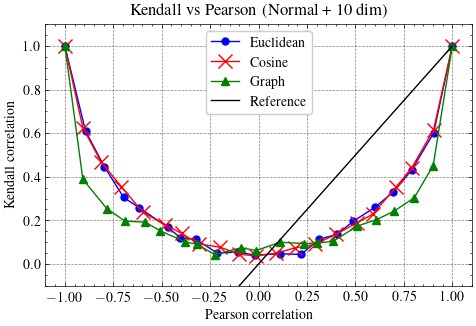

In [54]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
title_text = "Kendall vs Pearson (Normal + 10 dim)"
plt.title(title_text)
plt.grid()
plt.xlabel("Pearson correlation")
plt.ylabel("Kendall correlation")
plt.plot(arr_x1, arr_y1, 'b.-', markersize=10)
plt.plot(arr_x2, arr_y2, 'rx-', markersize=10)
plt.plot(arr_x3, arr_y3, 'g^-')
plt.plot([-1, 1], [-1, 1], color='black')

plt.legend(["Euclidean", "Cosine", "Graph", "Reference"], loc='upper center')
plt.grid()
plt.ylim(-0.1, 1.1)

plt.savefig("result_normal_10D.png", dpi=dpi_thesis)
plt.show()

#### 3.2.10. Uniform distribution + 10 dimensions (Euclidean vs cosine vs graph)

In [55]:
n_points = 50
dims = 10
dist = 'uniform'
diss = -1

arr_x1, arr_y1 = do_experiments(n_points=n_points, dims=dims, dist=dist, diss='euclidean')
arr_x2, arr_y2 = do_experiments(n_points=n_points, dims=dims, dist=dist, diss='cosine')
arr_x3, arr_y3 = do_experiments(n_points=n_points, dims=dims, dist=dist, diss='geodesic')

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:32<00:00,  1.54s/it]


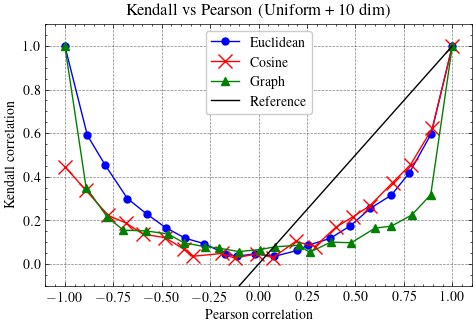

In [56]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
title_text = "Kendall vs Pearson (Uniform + 10 dim)"
plt.title(title_text)
plt.grid()
plt.xlabel("Pearson correlation")
plt.ylabel("Kendall correlation")
plt.plot(arr_x1, arr_y1, 'b.-', markersize=10)
plt.plot(arr_x2, arr_y2, 'rx-', markersize=10)
plt.plot(arr_x3, arr_y3, 'g^-')
plt.plot([-1, 1], [-1, 1], color='black')

plt.legend(["Euclidean", "Cosine", "Graph", "Reference"], loc='upper center')
plt.grid()
plt.ylim(-0.1, 1.1)

plt.savefig("result_uniform_10D.png", dpi=dpi_thesis)
plt.show()

#### 3.2.11. Bimodal distribution + 10 dimensions (Euclidean vs cosine vs graph)

In [57]:
n_points = 50
dims = 10
dist = 'bimodal'
diss = -1

arr_x1, arr_y1 = do_experiments(n_points=n_points, dims=dims, dist=dist, diss='euclidean')
arr_x2, arr_y2 = do_experiments(n_points=n_points, dims=dims, dist=dist, diss='cosine')
arr_x3, arr_y3 = do_experiments(n_points=n_points, dims=dims, dist=dist, diss='geodesic')

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.44s/it]


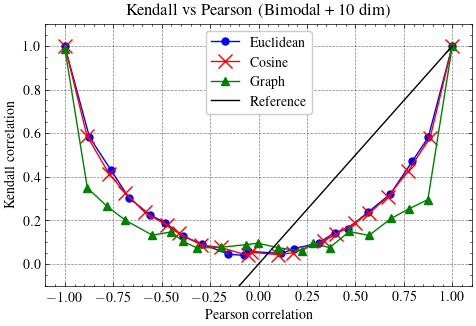

In [58]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
title_text = "Kendall vs Pearson (Bimodal + 10 dim)"
plt.title(title_text)
plt.grid()
plt.xlabel("Pearson correlation")
plt.ylabel("Kendall correlation")
plt.plot(arr_x1, arr_y1, 'b.-', markersize=10)
plt.plot(arr_x2, arr_y2, 'rx-', markersize=10)
plt.plot(arr_x3, arr_y3, 'g^-')
plt.plot([-1, 1], [-1, 1], color='black')

plt.legend(["Euclidean", "Cosine", "Graph", "Reference"], loc='upper center')
plt.grid()
plt.ylim(-0.1, 1.1)

plt.savefig("result_bimodal_10D.png", dpi=dpi_thesis)
plt.show()

## Appendix 1. Applying RSA toolbox

Let's try to use RSA toolbox instead of our own functions and compare the results.

In [59]:
def gen_data_apply_toolbox():
    
    n_points_in_experiment = 50
    n_corr_points = 100
    
    arr = np.zeros(100)
    arr_toolbox = np.zeros(100)

    for i in tqdm(range(n_corr_points)):
        
        corr = -1.0 + 0.02 * i
        
        # Generate data
        x, y = gen_data(corr=corr, n=n_points_in_experiment, plotting=False, dist='normal', dims=2)
        x_toolbox = rt.data.Dataset(x)
        y_toolbox = rt.data.Dataset(y)

        # Apply RSA
        rdm_x = calc_rdm(x, method='euclidean')
        rdm_y = calc_rdm(y, method='euclidean')
        rdm_x_toolbox = rt.rdm.calc_rdm(x_toolbox, method='euclidean')
        rdm_y_toolbox = rt.rdm.calc_rdm(y_toolbox, method='euclidean')

        # Compare RDMs
        corr_kendall = kendalltau(rdm_x, rdm_y)[0]
        corr_kendall_toolbox = rt.rdm.compare_kendall_tau(rdm_x_toolbox, rdm_y_toolbox)
        
        arr[i] = corr_kendall
        arr_toolbox[i] = corr_kendall_toolbox
        
    return (arr, arr_toolbox)

In [60]:
arr, arr_toolbox = gen_data_apply_toolbox()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Saveliy\AppData\Local\Temp\ipykernel_1980\2315911929.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  arr_toolbox[i] = corr_kendall_toolbox
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.65it/s]


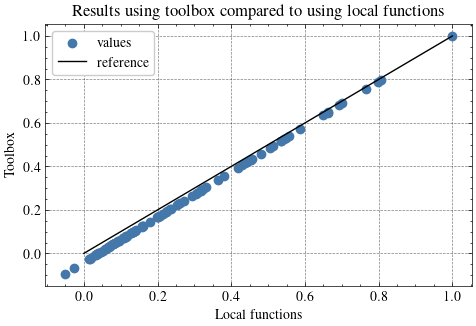

In [61]:
plt.figure(figsize=(figwidth_thesis, figheight_thesis))
plt.scatter(arr, arr_toolbox, label="values")
plt.xlabel("Local functions")
plt.ylabel("Toolbox")
plt.plot([0, 1], [0, 1], label="reference", color="black")
plt.title("Results using toolbox compared to using local functions")
plt.savefig("extra_toolbox_vs_local.png", dpi=dpi_thesis)
plt.legend()
plt.show()

In [62]:
print(arr[50])
print(arr_toolbox[50])

0.03502002370807036
-0.004399092970521543


As we can see, Kendall-tau correlations calculated from the same data are almost equal and are linearly dependent on each other. That means that local functions and functions from the toolbox for calculating RDMs and comparing them using Kendall-tau coefficient behave in the same way.

Note that in the pipelines we used the same data. Two pipelines were:

* `data -> calculating RDMs (local function) -> comparing RDMs (local function) -> Kendall-tau correlation`

* `data -> calculating RDMs (toolbox function) -> comparing RDMs (toolbox function) -> Kendall-tau correlation`

## Appendix 2. Exploring RDMs

We may want to check relations between two RDMs generated from two corresponding correlated arrays. To do that, we can flatten RDMs and plot dissimilarities against each otehr. Considering that we're interested in correlation between two RDMs (specifically, Kendall-tau correlation) and we calculate it between the same flattened arrays, we can as well plot them against each other.

**Uniform + euclidean + 10 dims, varying correlation**

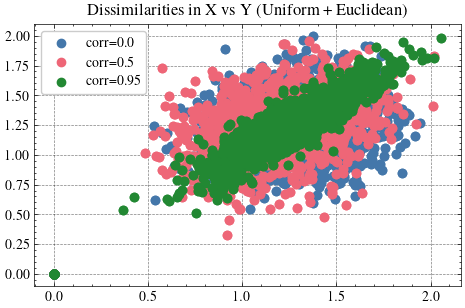

In [63]:
x1, y1 = gen_data(corr=0.0, n=50, plotting=False, dist='uniform', dims=10)
x2, y2 = gen_data(corr=0.5, n=50, plotting=False, dist='uniform', dims=10)
x3, y3 = gen_data(corr=0.95, n=50, plotting=False, dist='uniform', dims=10)

rdm_x1 = calc_rdm(x1, 'euclidean')
rdm_y1 = calc_rdm(y1, 'euclidean')
rdm_x2 = calc_rdm(x2, 'euclidean')
rdm_y2 = calc_rdm(y2, 'euclidean')
rdm_x3 = calc_rdm(x3, 'euclidean')
rdm_y3 = calc_rdm(y3, 'euclidean')

plt.figure(figsize=(figwidth_thesis, figheight_thesis))
plt.scatter(rdm_x1.flatten(), rdm_y1.flatten())
plt.scatter(rdm_x2.flatten(), rdm_y2.flatten())
plt.scatter(rdm_x3.flatten(), rdm_y3.flatten())
plt.title("Dissimilarities in X vs Y (Uniform + Euclidean)")
plt.legend(["corr=0.0", "corr=0.5", "corr=0.95"])
plt.savefig("extra_rdm_rdm_uniform_euclidean_10D.png", dpi=dpi_thesis)

**Uniform + cosine + 10 dims, varying correlation**

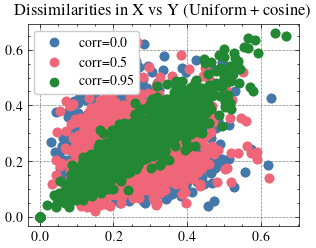

In [64]:
x1, y1 = gen_data(corr=0.0, n=50, plotting=False, dist='uniform', dims=10)
x2, y2 = gen_data(corr=0.5, n=50, plotting=False, dist='uniform', dims=10)
x3, y3 = gen_data(corr=0.95, n=50, plotting=False, dist='uniform', dims=10)

rdm_x1 = calc_rdm(x1, 'cosine')
rdm_y1 = calc_rdm(y1, 'cosine')
rdm_x2 = calc_rdm(x2, 'cosine')
rdm_y2 = calc_rdm(y2, 'cosine')
rdm_x3 = calc_rdm(x3, 'cosine')
rdm_y3 = calc_rdm(y3, 'cosine')

plt.scatter(rdm_x1.flatten(), rdm_y1.flatten())
plt.scatter(rdm_x2.flatten(), rdm_y2.flatten())
plt.scatter(rdm_x3.flatten(), rdm_y3.flatten())
plt.title("Dissimilarities in X vs Y (Uniform + cosine)")
plt.legend(["corr=0.0", "corr=0.5", "corr=0.95"])

**Uniform + euclidean + corr = 0.5, varying dimensions**

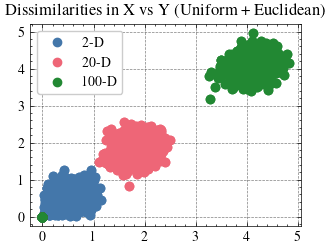

In [65]:
x1, y1 = gen_data(corr=0.5, n=50, plotting=False, dist='uniform', dims=2)
x2, y2 = gen_data(corr=0.5, n=50, plotting=False, dist='uniform', dims=20)
x3, y3 = gen_data(corr=0.5, n=50, plotting=False, dist='uniform', dims=100)

rdm_x1 = calc_rdm(x1, 'euclidean')
rdm_y1 = calc_rdm(y1, 'euclidean')
rdm_x2 = calc_rdm(x2, 'euclidean')
rdm_y2 = calc_rdm(y2, 'euclidean')
rdm_x3 = calc_rdm(x3, 'euclidean')
rdm_y3 = calc_rdm(y3, 'euclidean')

plt.scatter(rdm_x1.flatten(), rdm_y1.flatten())
plt.scatter(rdm_x2.flatten(), rdm_y2.flatten())
plt.scatter(rdm_x3.flatten(), rdm_y3.flatten())
plt.title("Dissimilarities in X vs Y (Uniform + Euclidean)")
plt.legend(["2-D", "20-D", "100-D"])

**Uniform + cosine + corr = 0.5, varying dimensions**

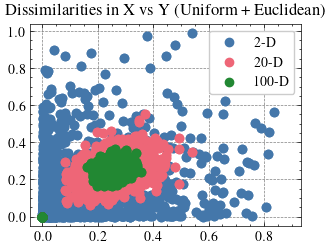

In [66]:
x1, y1 = gen_data(corr=0.5, n=50, plotting=False, dist='uniform', dims=2)
x2, y2 = gen_data(corr=0.5, n=50, plotting=False, dist='uniform', dims=20)
x3, y3 = gen_data(corr=0.5, n=50, plotting=False, dist='uniform', dims=100)

rdm_x1 = calc_rdm(x1, 'cosine')
rdm_y1 = calc_rdm(y1, 'cosine')
rdm_x2 = calc_rdm(x2, 'cosine')
rdm_y2 = calc_rdm(y2, 'cosine')
rdm_x3 = calc_rdm(x3, 'cosine')
rdm_y3 = calc_rdm(y3, 'cosine')

plt.scatter(rdm_x1.flatten(), rdm_y1.flatten())
plt.scatter(rdm_x2.flatten(), rdm_y2.flatten())
plt.scatter(rdm_x3.flatten(), rdm_y3.flatten())
plt.title("Dissimilarities in X vs Y (Uniform + Euclidean)")
plt.legend(["2-D", "20-D", "100-D"])